In [1]:
%matplotlib inline
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/pyparsing.py:2927: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
experiment = 'data/original/*/*'

In [3]:
meps = sorted(glob.glob(experiment + '/mep/*/*.txt'))
mep_present = len(meps) > 0
eegs = sorted(glob.glob(experiment + '/eeg/*/clean.set'))
eeg_present = len(eegs) > 0
all_present = mep_present and eeg_present
print(all_present)

True


In [4]:
eegs = [
    'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set',
    'data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub08/exp01/eeg/SP 110RMT r1/clean.set',
    'data/original/sub10/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub11/exp01/eeg/SP 110RMT/clean.set',
    'data/original/sub13/exp01/eeg/SP 110RMT/clean.set'
]

In [5]:
# Read EEG file and prepare epochs in dataframes.
def read_eeg(path):
    epochs = read_epochs_eeglab(path)
    epochs = epochs.pick_channels(ch_names=['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'])
    epoch_list = []
    i = 0
    for epoch in epochs.iter_evoked():
        df = epoch.to_data_frame()
        epoch_list.append(df)
    return epoch_list

In [6]:
# Select EEG before TMS.
def crop_epochs(epoch_list, duration_millis=500, sampling_rate=1000):
    new_epoch_list = []
    for epoch_df in epoch_list:
        # Delete EEG after TMS event.
        epoch_df['signal time'] = epoch_df.index
        epoch_df = epoch_df.reset_index()
        indices = epoch_df.index[epoch_df['signal time'] == 0].tolist()
        event_index = int(len(indices)/2)
        delete_count = epoch_df.shape[0] - indices[event_index]
        epoch_df = epoch_df.drop(epoch_df.tail(delete_count).index)

        # Select EEG for the selected duration.
        keep = int(duration_millis * sampling_rate / 1000)
        delete_count = epoch_df.shape[0] - keep
        epoch_df = epoch_df.drop(epoch_df.head(delete_count).index)

        # Append the epoch in the list.
        epoch_df = epoch_df.set_index('signal time')
        new_epoch_list.append(epoch_df)
    return new_epoch_list, -keep

In [7]:
# Open MEP file as dataframe.
def open_mep_as_df(path):
    fileMep = open(path, "r+")
    mep_frames = fileMep.read().split('\n\n')
    df_list = []
    for mep_frame in mep_frames:
        df_list.append(pd.read_csv(StringIO(mep_frame), '\t'))
    return df_list

In [8]:
# Function to get APB column name.
def get_apb_column_name(mep_frame):
    if 'L APB' in mep_frame:
        return 'L APB'
    else:
        return 'APB'

In [9]:
# Function to crop MEP region.
def crop_mep_region(mep_frame):
    crop_start = 0.211
    crop_end = 0.4
    multiplier = 7499 / 1.4998
    start = int(crop_start * multiplier)
    end = int(crop_end * multiplier)
    mep_cropped = mep_frame.iloc[start:end, :]
    time = mep_frame.iloc[start:end, :]
    return mep_cropped, time

In [10]:
# Calculate MEP size.
def calculate_mep_size(mep_frame):
    mep_cropped, time = crop_mep_region(mep_frame)
    apb_name = get_apb_column_name(mep_frame)
    max_row = mep_frame.iloc[mep_cropped.idxmax(axis=0)[apb_name]]
    min_row = mep_frame.iloc[mep_cropped.idxmin(axis=0)[apb_name]]
    mep_size = max_row[apb_name] - min_row[apb_name]
    return mep_size

In [11]:
# Calculate EEG area.
def calculate_eeg_area(epoch_df):
    gfp = np.sum(epoch_df ** 2, axis=1)
    times = gfp.index
    gfp = mne.baseline.rescale(gfp.values, times, baseline=(None, 0))
    return np.trapz(gfp, times)

In [12]:
# Calculate EEG frequency.
def calculate_eeg_frequency(channel):
    sf = 1000
    win = 4 * sf
    freqs, psd = signal.welch(channel, sf, nperseg=win)
    return freqs, psd

In [13]:
def calculate_eeg_max_amplitude(epoch_df):
    avg = epoch_df.mean(axis=1)
    return np.max(avg.values)

In [14]:
def filter_electrodes(epoch, which='lm1'):
    if which == 'ltm1':
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC2',
                'FC6', 'M1', 'T7', 'Cz', 'C4', 'T8', 'M2', 'CP2',
                'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FCz', 'FC4',
                'C2', 'C6', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)
    else:
        return epoch.drop(['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1',
                'M1', 'T7', 'C3', 'Cz', 'T8', 'M2', 'CP5', 'CP1',
                'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'O2', 'EOG', 'AF7',
                'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCz', 'C5',
                'C1', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3',
                'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'Oz'], axis=1)

In [15]:
def band_max(freq, psd, start=0, end=4):
    start = np.where(freq==start)
    if len(start) > 0:
        start = start[0][0]
    else:
        start = 0
    end = np.where(freq==end)
    if len(end) > 0:
        end = end[0][0]
    else:
        end = start + 4
    freq = freq[start:end]
    psd = psd[start:end]
    i = np.argmax(np.abs(psd))
    return freq[i], psd[i]

In [16]:
def extract_features(eeg_path, mep_path):
    epochs = read_eeg(eeg_path)
    epochs, _ = crop_epochs(epochs)
    mep_frames = open_mep_as_df(mep_path)
    if len(epochs) != len(mep_frames):
        raise Exception('MEP frame count (' + str(len(mep_frames)) + ') is not equal to EEG epochs count (' + str(len(epochs)) + ') for ' + eeg_path)
        return
    epoch_features = []
    for i in range(len(epochs)):
        epoch = epochs[i]
        mep = mep_frames[i]
        segments = eeg_path.split('/')
        d = {'sub': segments[2], 'exp': segments[3], 'run': segments[5], 'epoch': i}

        freq, psd = calculate_eeg_frequency(epoch.drop('time', axis=1).values.mean(axis=1))
        d['all_all_max_power_freq'], d['all_all_max_power'] = band_max(freq, psd, 4, 40)
        d['all_delta_max_power_freq'], d['all_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['all_theta_max_power_freq'], d['all_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['all_alpha_max_power_freq'], d['all_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['all_beta_max_power_freq'], d['all_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['all_gamma_max_power_freq'], d['all_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'ltm1').values.mean(axis=1))
        d['ltm1_all_max_power_freq'], d['ltm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['ltm1_delta_max_power_freq'], d['ltm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['ltm1_theta_max_power_freq'], d['ltm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['ltm1_alpha_max_power_freq'], d['ltm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['ltm1_beta_max_power_freq'], d['ltm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['ltm1_gamma_max_power_freq'], d['ltm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        freq, psd = calculate_eeg_frequency(filter_electrodes(epoch.drop('time', axis=1), 'rtm1').values.mean(axis=1))
        d['rtm1_all_max_power_freq'], d['rtm1_all_max_power'] = band_max(freq, psd, 4, 40)
        d['rtm1_delta_max_power_freq'], d['rtm1_delta_max_power'] = band_max(freq, psd, 0, 4)
        d['rtm1_theta_max_power_freq'], d['rtm1_theta_max_power'] = band_max(freq, psd, 4, 8)
        d['rtm1_alpha_max_power_freq'], d['rtm1_alpha_max_power'] = band_max(freq, psd, 8, 16)
        d['rtm1_beta_max_power_freq'], d['rtm1_beta_max_power'] = band_max(freq, psd, 16, 32)
        d['rtm1_gamma_max_power_freq'], d['rtm1_gamma_max_power'] = band_max(freq, psd, 32, 500)

        d['area_under_eeg'] = calculate_eeg_area(epoch.drop('time', axis=1))
        d['rtm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_area_under_eeg'] = calculate_eeg_area(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))
        d['all_max_amplitude'] = calculate_eeg_max_amplitude(epoch.drop('time', axis=1))
        d['rtm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'rtm1'))
        d['ltm1_max_amplitude'] = calculate_eeg_max_amplitude(filter_electrodes(epoch.drop('time', axis=1), 'ltm1'))

        d['mep_size'] = calculate_mep_size(mep)
        epoch_features.append(d)
    return epoch_features

In [17]:
features = []
eegs_to_ignore = ['data/original/sub05/exp01/eeg/SP 110RMT r3/clean.set', 
                  'data/original/sub01/exp01/eeg/SP 110RMT r1/clean.set']
for eeg_path in eegs:
    if (eeg_path in eegs_to_ignore):
        continue
    segments = eeg_path.split('/')
    segments[4] = 'mep'
    segments = segments[:-1]
    mep_path = '/'.join(segments) + '/*.txt'
    mep_path = glob.glob(mep_path)[0]
    features = features + extract_features(eeg_path, mep_path)

Extracting parameters from data/original/sub03/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub04/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub06/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub07/exp01/eeg/SP 110RMT r1/clean.set...
50 matching events found
No baselin

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'n

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub10/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub11/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))


Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int6

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Extracting parameters from data/original/sub13/exp01/eeg/SP 110RMT/clean.set...
50 matching events found
No baseline correction applied
Not setting metadata


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

0 projection items activated
Ready.
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Converting "time" to "<class 'numpy.int64'>"...
Conv

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input length  = 500, using nperseg = 500
  .format(nperseg, input_length))
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 4000 is greater than input leng

In [18]:
df = pd.DataFrame(features)
df.tail()

,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_max_amplitude,rtm1_theta_max_power,rtm1_theta_max_power_freq,run,sub
395,3.070459,6.0,2.520586,8.0,0.986132,20.0,2.620692,2.0,1.103089,100.0,...,26.0,0.898686,2.0,1.181469,100.0,9.100235,0.289339,6.0,SP 110RMT,sub13
396,0.638348,4.0,0.360533,10.0,0.539118,20.0,0.531366,2.0,1.131792,100.0,...,16.0,0.077720,0.0,1.214964,100.0,9.086019,0.024770,4.0,SP 110RMT,sub13
397,2.787538,6.0,2.763635,8.0,0.277856,20.0,1.918599,2.0,1.035143,100.0,...,26.0,0.935069,2.0,1.162532,100.0,15.361268,3.091663,4.0,SP 110RMT,sub13
398,5.071670,4.0,0.544242,12.0,0.738336,26.0,7.723836,2.0,0.981040,100.0,...,22.0,2.069256,2.0,1.111546,100.0,14.017723,3.837734,4.0,SP 110RMT,sub13
399,2.483447,18.0,0.492894,8.0,2.483447,18.0,0.375550,2.0,0.729317,100.0,...,16.0,0.204073,2.0,0.970523,100.0,11.220786,0.747829,4.0,SP 110RMT,sub13


In [19]:
print(df.shape)
print(df.columns)

(400, 47)
Index(['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg', 'epoch', 'exp',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
       'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
       'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
       'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
       'ltm1_max_amplitude', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'mep_size', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
       'rtm1_beta_max_power', 'rtm1_

Text(0, 0.5, 'MEP Size')

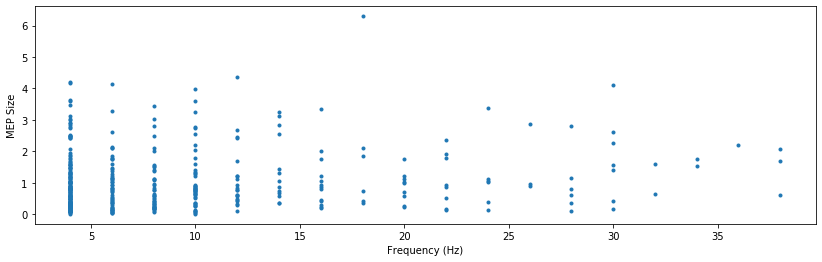

In [20]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_all_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

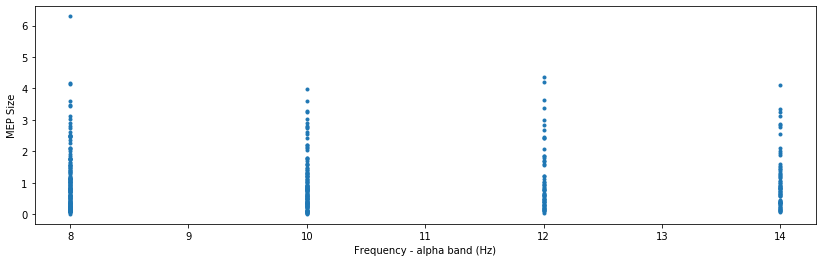

In [21]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_alpha_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

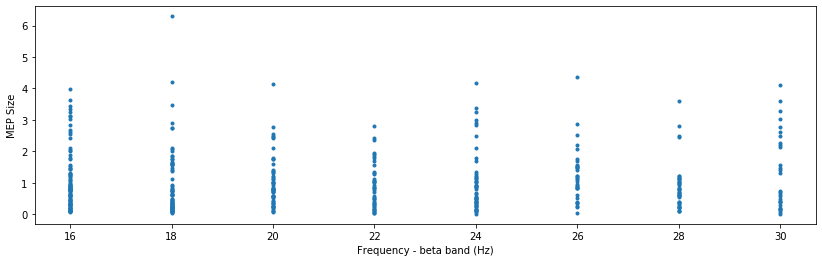

In [22]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_beta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - beta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

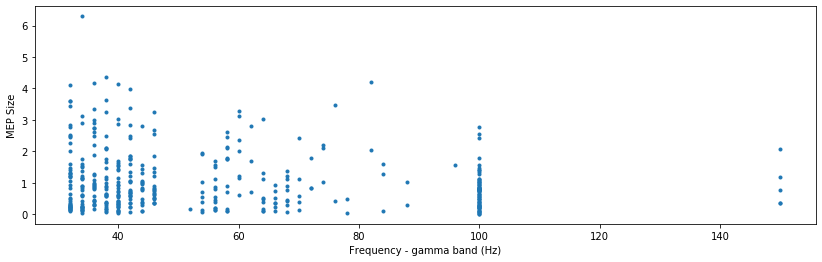

In [23]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_gamma_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - gamma band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

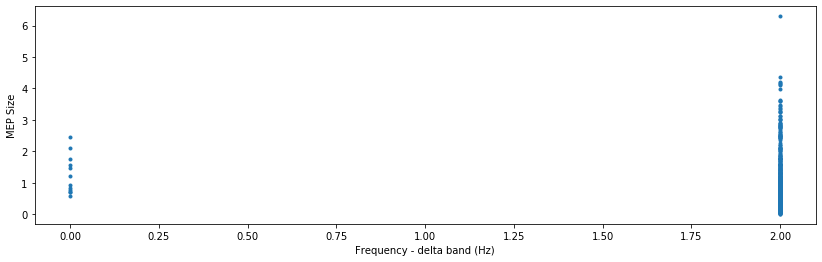

In [24]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_delta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - delta band (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

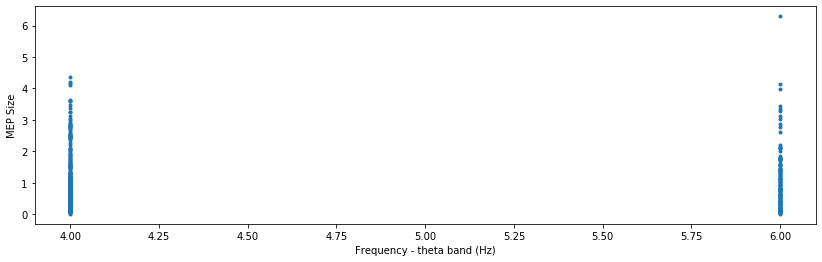

In [25]:
plt.figure(figsize=(14,4))
plt.plot(df['ltm1_theta_max_power_freq'], df['mep_size'], '.')
plt.xlabel('Frequency - theta band (Hz)')
plt.ylabel('MEP Size')

In [26]:
df2 = df.groupby(['sub', 'exp', 'run']).mean()
df2.head()

,,,all_all_max_power,all_all_max_power_freq,all_alpha_max_power,all_alpha_max_power_freq,all_beta_max_power,all_beta_max_power_freq,all_delta_max_power,all_delta_max_power_freq,all_gamma_max_power,all_gamma_max_power_freq,...,rtm1_area_under_eeg,rtm1_beta_max_power,rtm1_beta_max_power_freq,rtm1_delta_max_power,rtm1_delta_max_power_freq,rtm1_gamma_max_power,rtm1_gamma_max_power_freq,rtm1_max_amplitude,rtm1_theta_max_power,rtm1_theta_max_power_freq
sub,exp,run,,,,,,,,,,,,,,,,,,,,,
sub03,exp01,SP 110RMT r1,2.600773,9.48,1.753271,10.16,1.050128,20.24,2.167120,2.00,0.743320,87.64,...,-620.149822,1.559353,20.84,5.959500,2.00,0.817214,59.32,19.744948,4.144221,4.64
sub04,exp01,SP 110RMT r1,44.100969,11.72,24.202340,10.72,26.395078,21.88,72.780786,1.88,20.191874,46.60,...,-287.760898,62.164819,21.68,204.106754,1.92,48.826627,48.16,143.307574,72.887499,4.68
sub06,exp01,SP 110RMT r1,4.129349,7.68,3.654683,9.56,0.837222,19.64,2.026464,1.88,0.493285,45.00,...,76.617940,1.418235,19.92,3.517348,1.96,0.887064,42.32,16.674395,3.565226,4.64
sub07,exp01,SP 110RMT r1,31.748715,7.64,18.652632,10.48,10.531344,20.16,62.016727,1.92,6.894438,67.04,...,-67373.977404,62.725740,20.60,366.753689,2.00,37.806419,48.32,181.860637,172.147980,4.72
sub08,exp01,SP 110RMT r1,5.753799,8.88,2.617916,10.60,1.502017,21.68,10.028095,1.96,0.902747,46.12,...,-1134.266747,5.509516,21.60,36.667977,2.00,3.620606,46.60,57.579572,16.458864,4.56


In [27]:
df2.shape

(8, 44)

Text(0, 0.5, 'MEP Size')

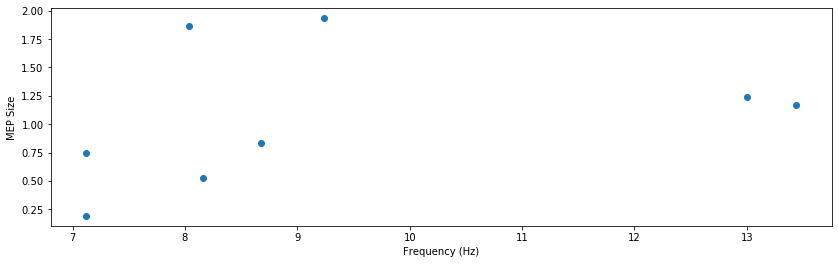

In [28]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_all_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

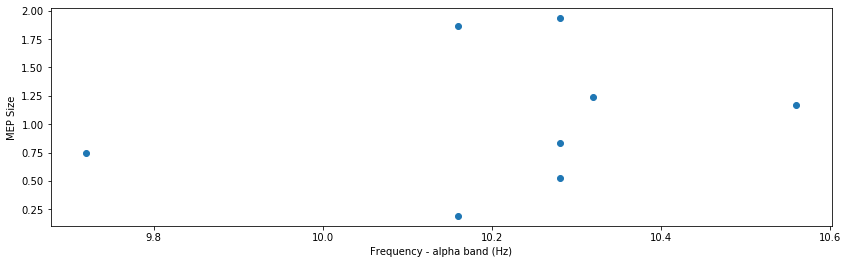

In [29]:
plt.figure(figsize=(14,4))
plt.plot(df2['ltm1_alpha_max_power_freq'], df2['mep_size'], 'o')
plt.xlabel('Frequency - alpha band (Hz)')
plt.ylabel('MEP Size')

# Frequency bins

In [30]:
bins = [0, 4, 8, 16, 32, 100]
df3_mean = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).mean()
df3_max = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).max()
df3_min = df.groupby(pd.cut(df['rtm1_all_max_power_freq'], bins)).min()
df3_mean['mep_size_mean'] = df3_mean['mep_size']
df3_mean['mep_size_max'] = df3_max['mep_size']
df3_mean['mep_size_min'] = df3_min['mep_size']
df3_mean['rtm1_all_max_power_freq'] = df3_mean.index

In [31]:
df3_mean[['rtm1_all_max_power_freq', 'mep_size_mean', 'mep_size_max', 'mep_size_min']]

,rtm1_all_max_power_freq,mep_size_mean,mep_size_max,mep_size_min
rtm1_all_max_power_freq,,,,
"(0, 4]","(0, 4]",0.910236,3.626404,0.010834
"(4, 8]","(4, 8]",1.123645,4.125977,0.033570
"(8, 16]","(8, 16]",1.047863,4.376983,0.023956
"(16, 32]","(16, 32]",1.448293,6.295166,0.124969
"(32, 100]","(32, 100]",1.351501,3.257141,0.031281


Text(0.5, 1.0, 'Left M1 Electrode Frequency Bins vs MEP Size')

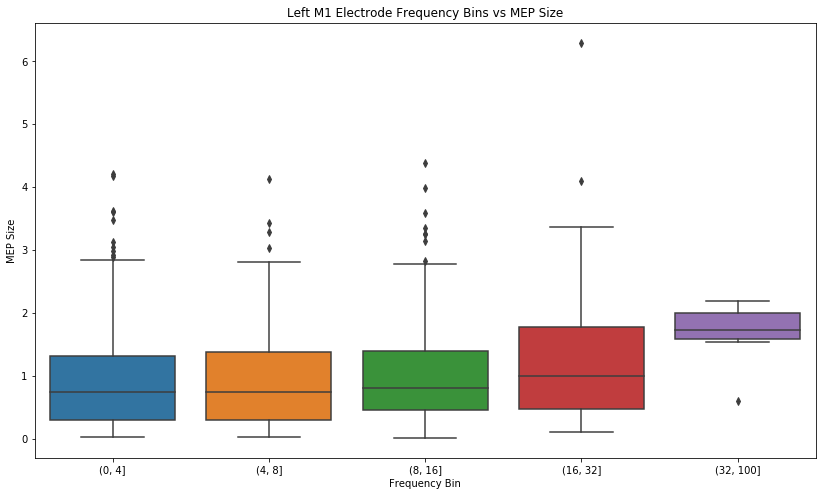

In [32]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['ltm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Left M1 Electrode Frequency Bins vs MEP Size')

Text(0.5, 1.0, 'Right M1 Electrode Frequency Bins vs MEP Size')

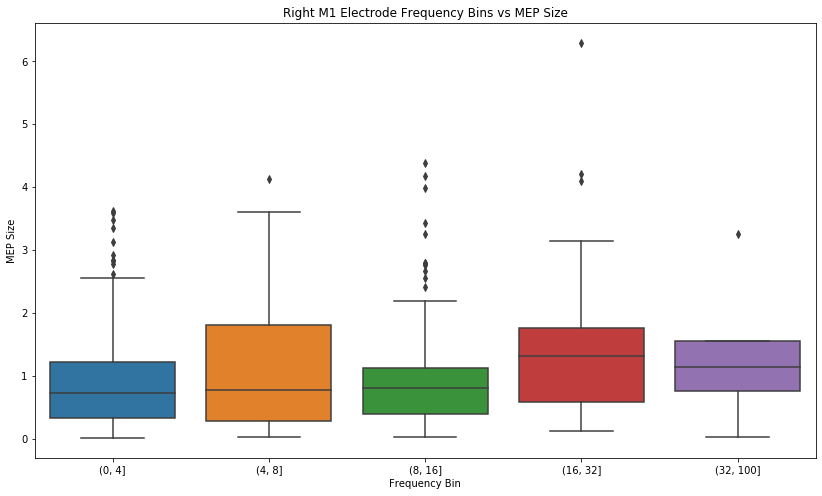

In [33]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['rtm1_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('Right M1 Electrode Frequency Bins vs MEP Size')

Text(0.5, 1.0, 'All Electrodes Frequency Bins vs MEP Size')

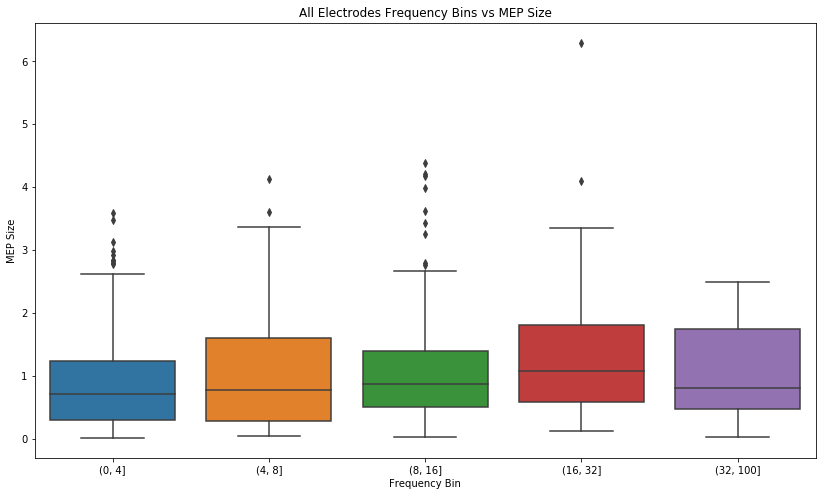

In [34]:
df4 = df
bins = [0, 4, 8, 16, 32, 100]
df4['bin'] = pd.cut(df4['all_all_max_power_freq'], bins)
df4.head()

fig = plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="bin", y="mep_size", data=df4)
ax.set_xlabel('Frequency Bin')
ax.set_ylabel('MEP Size')
ax.set_title('All Electrodes Frequency Bins vs MEP Size')

Text(0, 0.5, 'MEP Size')

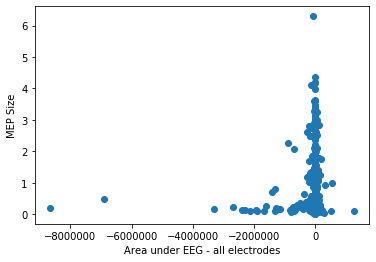

In [35]:
plt.plot(df4['area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - all electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

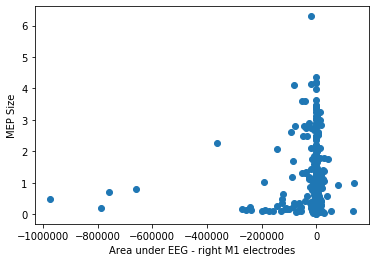

In [36]:
plt.plot(df4['rtm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - right M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

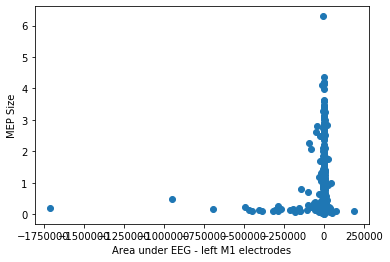

In [37]:
plt.plot(df4['ltm1_area_under_eeg'], df4['mep_size'], 'o')
plt.xlabel('Area under EEG - left M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

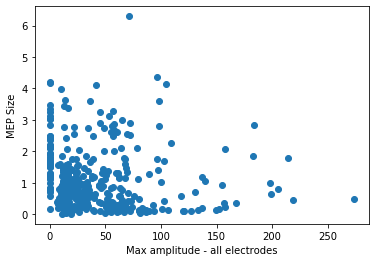

In [38]:
plt.plot(df4['all_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - all electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

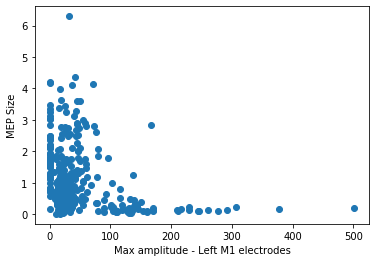

In [39]:
plt.plot(df4['ltm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Left M1 electrodes')
plt.ylabel('MEP Size')

Text(0, 0.5, 'MEP Size')

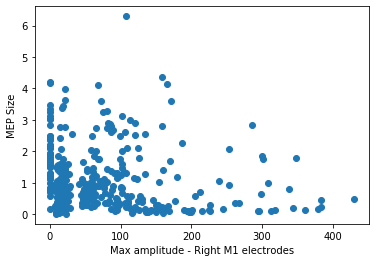

In [40]:
plt.plot(df4['rtm1_max_amplitude'], df4['mep_size'], 'o')
plt.xlabel('Max amplitude - Right M1 electrodes')
plt.ylabel('MEP Size')

# Linear Regression

In [41]:
df.dtypes

all_all_max_power             float64
all_all_max_power_freq        float64
all_alpha_max_power           float64
all_alpha_max_power_freq      float64
all_beta_max_power            float64
all_beta_max_power_freq       float64
all_delta_max_power           float64
all_delta_max_power_freq      float64
all_gamma_max_power           float64
all_gamma_max_power_freq      float64
all_max_amplitude             float64
all_theta_max_power           float64
all_theta_max_power_freq      float64
area_under_eeg                float64
epoch                           int64
exp                            object
ltm1_all_max_power            float64
ltm1_all_max_power_freq       float64
ltm1_alpha_max_power          float64
ltm1_alpha_max_power_freq     float64
ltm1_area_under_eeg           float64
ltm1_beta_max_power           float64
ltm1_beta_max_power_freq      float64
ltm1_delta_max_power          float64
ltm1_delta_max_power_freq     float64
ltm1_gamma_max_power          float64
ltm1_gamma_m

In [42]:
x = df[['all_all_max_power', 'all_all_max_power_freq', 'all_alpha_max_power',
       'all_alpha_max_power_freq', 'all_beta_max_power',
       'all_beta_max_power_freq', 'all_delta_max_power',
       'all_delta_max_power_freq', 'all_gamma_max_power',
       'all_gamma_max_power_freq', 'all_max_amplitude', 'all_theta_max_power',
       'all_theta_max_power_freq', 'area_under_eeg',
       'ltm1_all_max_power', 'ltm1_all_max_power_freq', 'ltm1_alpha_max_power',
       'ltm1_alpha_max_power_freq', 'ltm1_area_under_eeg',
       'ltm1_beta_max_power', 'ltm1_beta_max_power_freq',
       'ltm1_delta_max_power', 'ltm1_delta_max_power_freq',
       'ltm1_gamma_max_power', 'ltm1_gamma_max_power_freq',
       'ltm1_max_amplitude', 'ltm1_theta_max_power',
       'ltm1_theta_max_power_freq', 'rtm1_all_max_power',
       'rtm1_all_max_power_freq', 'rtm1_alpha_max_power',
       'rtm1_alpha_max_power_freq', 'rtm1_area_under_eeg',
       'rtm1_beta_max_power', 'rtm1_beta_max_power_freq',
       'rtm1_delta_max_power', 'rtm1_delta_max_power_freq',
       'rtm1_gamma_max_power', 'rtm1_gamma_max_power_freq',
       'rtm1_max_amplitude', 'rtm1_theta_max_power',
       'rtm1_theta_max_power_freq']]
y = df['mep_size']

In [43]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=23)

In [44]:
model = LinearRegression().fit(x_train, y_train)

In [45]:
y_predicted = model.predict(x_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print(r2)

-0.09396367947216344


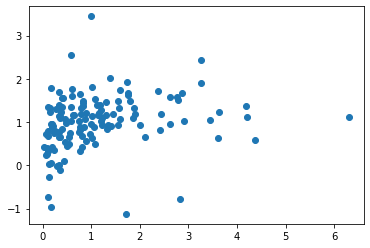

In [46]:
plt.plot(y_test, y_predicted, 'o')

# TPOT

In [49]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))

Generation 1 - Current best internal CV score: -0.5589140345727012
Generation 2 - Current best internal CV score: -0.5568512689359931
Generation 3 - Current best internal CV score: -0.5568512689359931
Generation 4 - Current best internal CV score: -0.5568512689359931
Generation 5 - Current best internal CV score: -0.5540606783985977
Generation 6 - Current best internal CV score: -0.5481045048072812
Generation 7 - Current best internal CV score: -0.5469335929636495
Generation 8 - Current best internal CV score: -0.5469335929636495
Generation 9 - Current best internal CV score: -0.5469335929636495
Generation 10 - Current best internal CV score: -0.5465517335345702
Generation 11 - Current best internal CV score: -0.5369737429795142
Generation 12 - Current best internal CV score: -0.5369737429795142
Generation 13 - Current best internal CV score: -0.5277466136786448
Generation 14 - Current best internal CV score: -0.5209193009221281
Generation 15 - Current best internal CV score: -0.520919

/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:668: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


In [50]:
tpot.export('tpot_pipeline.py')

In [51]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_pipeline2.py')

Generation 1 - Current best internal CV score: 0.26978446977117143
Generation 2 - Current best internal CV score: 0.2759173457487637
Generation 3 - Current best internal CV score: 0.2759173457487637
Generation 4 - Current best internal CV score: 0.27835271824174945
Generation 5 - Current best internal CV score: 0.2815290928374915
Generation 6 - Current best internal CV score: 0.28265339364809056
Generation 7 - Current best internal CV score: 0.28265339364809056
Generation 8 - Current best internal CV score: 0.2857542921417894
Generation 9 - Current best internal CV score: 0.2945125445147874
Generation 10 - Current best internal CV score: 0.2945125445147874
Generation 11 - Current best internal CV score: 0.2945125445147874
Generation 12 - Current best internal CV score: 0.3026423400930839
Generation 13 - Current best internal CV score: 0.3170798736137616
Generation 14 - Current best internal CV score: 0.3170798736137616
Generation 15 - Current best internal CV score: 0.3170798736137616


In [58]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400, scoring='r2')
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_pipeline3.py')

Generation 1 - Current best internal CV score: 0.291454387008542
Generation 2 - Current best internal CV score: 0.3105289208484208
Generation 3 - Current best internal CV score: 0.3105289208484208
Generation 4 - Current best internal CV score: 0.3105289208484208
Generation 5 - Current best internal CV score: 0.3105289208484208
Generation 6 - Current best internal CV score: 0.3105289208484208
Generation 7 - Current best internal CV score: 0.32492272619712276
Generation 8 - Current best internal CV score: 0.32492272619712276
Generation 9 - Current best internal CV score: 0.32492272619712276
Generation 10 - Current best internal CV score: 0.32492272619712276
Generation 11 - Current best internal CV score: 0.3262258697417805
Generation 12 - Current best internal CV score: 0.3262258697417805
Generation 13 - Current best internal CV score: 0.3262258697417805
Generation 14 - Current best internal CV score: 0.3264768086830695
Generation 15 - Current best internal CV score: 0.3264768086830695
G

Generation 123 - Current best internal CV score: 0.3500744103649722
Generation 124 - Current best internal CV score: 0.3500744103649722
Generation 125 - Current best internal CV score: 0.3500744103649722
Generation 126 - Current best internal CV score: 0.3500744103649722
Generation 127 - Current best internal CV score: 0.3500744103649722
Generation 128 - Current best internal CV score: 0.3500744103649722
Generation 129 - Current best internal CV score: 0.3500744103649722
Generation 130 - Current best internal CV score: 0.3500744103649722
Generation 131 - Current best internal CV score: 0.3500744103649722
Generation 132 - Current best internal CV score: 0.3500744103649722
Generation 133 - Current best internal CV score: 0.3500744103649722
Generation 134 - Current best internal CV score: 0.3500744103649722
Generation 135 - Current best internal CV score: 0.3500744103649722
Generation 136 - Current best internal CV score: 0.3500744103649722
Generation 137 - Current best internal CV score:

Generation 244 - Current best internal CV score: 0.3645719661146765
Generation 245 - Current best internal CV score: 0.3645719661146765
Generation 246 - Current best internal CV score: 0.3645719661146765
Generation 247 - Current best internal CV score: 0.3645719661146765
Generation 248 - Current best internal CV score: 0.3645719661146765
Generation 249 - Current best internal CV score: 0.3645719661146765
Generation 250 - Current best internal CV score: 0.3645719661146765
Generation 251 - Current best internal CV score: 0.3645719661146765
Generation 252 - Current best internal CV score: 0.3645719661146765
Generation 253 - Current best internal CV score: 0.3645719661146765
Generation 254 - Current best internal CV score: 0.3645719661146765
Generation 255 - Current best internal CV score: 0.3645719661146765
Generation 256 - Current best internal CV score: 0.3645719661146765
Generation 257 - Current best internal CV score: 0.3645719661146765
Generation 258 - Current best internal CV score:

Generation 364 - Current best internal CV score: 0.36603794750689644
Generation 365 - Current best internal CV score: 0.36603794750689644
Generation 366 - Current best internal CV score: 0.36603794750689644
Generation 367 - Current best internal CV score: 0.36603794750689644
Generation 368 - Current best internal CV score: 0.36603794750689644
Generation 369 - Current best internal CV score: 0.36603794750689644
Generation 370 - Current best internal CV score: 0.36603794750689644
Generation 371 - Current best internal CV score: 0.36603794750689644
Generation 372 - Current best internal CV score: 0.36603794750689644
Generation 373 - Current best internal CV score: 0.36603794750689644
Generation 374 - Current best internal CV score: 0.36603794750689644
Generation 375 - Current best internal CV score: 0.36603794750689644
Generation 376 - Current best internal CV score: 0.36603794750689644
Generation 377 - Current best internal CV score: 0.36603794750689644
Generation 378 - Current best inte

In [53]:
tpot = TPOTRegressor(n_jobs=-1, verbosity=2, generations=400, population_size=400)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
predictions = tpot.predict(x_test)
print("R2 score:", sklearn.metrics.r2_score(y_test, predictions))
tpot.export('tpot_pipeline4.py')

Generation 1 - Current best internal CV score: -0.5544494786476478
Generation 2 - Current best internal CV score: -0.5544494786476478
Generation 3 - Current best internal CV score: -0.5544494786476478
Generation 4 - Current best internal CV score: -0.546638601463029
Generation 5 - Current best internal CV score: -0.5462211099481322
Generation 6 - Current best internal CV score: -0.5462211099481322
Generation 7 - Current best internal CV score: -0.5424667745042442
Generation 8 - Current best internal CV score: -0.5424667745042442
Generation 9 - Current best internal CV score: -0.5385172344058435
Generation 10 - Current best internal CV score: -0.5368722400935734
Generation 11 - Current best internal CV score: -0.5368722400935734
Generation 12 - Current best internal CV score: -0.5368722400935734
Generation 13 - Current best internal CV score: -0.5332188391226411
Generation 14 - Current best internal CV score: -0.5332188391226411
Generation 15 - Current best internal CV score: -0.5303773

Generation 122 - Current best internal CV score: -0.488643815404359
Generation 123 - Current best internal CV score: -0.488643815404359
Generation 124 - Current best internal CV score: -0.488643815404359
Generation 125 - Current best internal CV score: -0.488643815404359
Generation 126 - Current best internal CV score: -0.488643815404359
Generation 127 - Current best internal CV score: -0.488643815404359
Generation 128 - Current best internal CV score: -0.488643815404359
Generation 129 - Current best internal CV score: -0.488643815404359
Generation 130 - Current best internal CV score: -0.488643815404359
Generation 131 - Current best internal CV score: -0.4857152103306028
Generation 132 - Current best internal CV score: -0.4857152103306028
Generation 133 - Current best internal CV score: -0.47952910627116874
Generation 134 - Current best internal CV score: -0.47952910627116874
Generation 135 - Current best internal CV score: -0.47952910627116874
Generation 136 - Current best internal C

Generation 241 - Current best internal CV score: -0.4685936946732583
Generation 242 - Current best internal CV score: -0.4685936946732583
Generation 243 - Current best internal CV score: -0.4685936946732583
Generation 244 - Current best internal CV score: -0.4685936946732583
Generation 245 - Current best internal CV score: -0.4685936946732583
Generation 246 - Current best internal CV score: -0.4685936946732583
Generation 247 - Current best internal CV score: -0.4685936946732583
Generation 248 - Current best internal CV score: -0.4685936946732583
Generation 249 - Current best internal CV score: -0.4685936946732583
Generation 250 - Current best internal CV score: -0.4685936946732583
Generation 251 - Current best internal CV score: -0.4685936946732583
Generation 252 - Current best internal CV score: -0.4685936946732583
Generation 253 - Current best internal CV score: -0.4685936946732583
Generation 254 - Current best internal CV score: -0.4685936946732583
Generation 255 - Current best inte

Generation 360 - Current best internal CV score: -0.46570807586167173
Generation 361 - Current best internal CV score: -0.46570807586167173
Generation 362 - Current best internal CV score: -0.46570807586167173
Generation 363 - Current best internal CV score: -0.46570807586167173
Generation 364 - Current best internal CV score: -0.46570807586167173
Generation 365 - Current best internal CV score: -0.46570807586167173
Generation 366 - Current best internal CV score: -0.46570807586167173
Generation 367 - Current best internal CV score: -0.46570807586167173
Generation 368 - Current best internal CV score: -0.46570807586167173
Generation 369 - Current best internal CV score: -0.4648468109523711
Generation 370 - Current best internal CV score: -0.4648468109523711
Generation 371 - Current best internal CV score: -0.4648468109523711
Generation 372 - Current best internal CV score: -0.4648468109523711
Generation 373 - Current best internal CV score: -0.4648468109523711
Generation 374 - Current 

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LassoLarsCV
from sklearn.svm import LinearSVR
from sklearn.preprocessing import MinMaxScaler

In [57]:
model = RandomForestRegressor(GradientBoostingRegressor(ExtraTreesRegressor(DecisionTreeRegressor(SelectPercentile(Normalizer(SelectPercentile(LassoLarsCV(MinMaxScaler(LinearSVR(SelectPercentile(MinMaxScaler(SelectPercentile(x_train, percentile=9)), percentile=81), C=25.0, dual=False, epsilon=0.1, loss=squared_epsilon_insensitive, tol=1e-05)), normalize=True), percentile=82), norm=l1), percentile=4), max_depth=10, min_samples_leaf=12, min_samples_split=8), bootstrap=True, max_features=0.1, min_samples_leaf=18, min_samples_split=4, n_estimators=100), alpha=0.85, learning_rate=0.01, loss=ls, max_depth=7, max_features=0.8500000000000001, min_samples_leaf=6, min_samples_split=20, n_estimators=100, subsample=0.2), bootstrap=True, max_features=0.2, min_samples_leaf=11, min_samples_split=11, n_estimators=100)

NameError: name 'squared_epsilon_insensitive' is not defined